# ProductListPriceHistory

## Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [3]:
sql_query = "SELECT * FROM ProductListPriceHistory"
productlistpricehistory_df = read_data_return_df(sql_query, engine)

productlistpricehistory_df.head()

,PRODUCTLISTPRICEHISTORY_sk,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCTLISTPRICEHISTORY_datetime_added
0,1,222,2011-05-31,2012-05-29,33.6442,2024-05-25 08:07:50.517
1,2,222,2012-05-30,2013-05-29,33.6442,2024-05-25 08:07:50.517
2,3,222,2013-05-30,None,34.9900,2024-05-25 08:07:50.517
3,4,228,2011-05-31,2012-05-29,33.6442,2024-05-25 08:07:50.517
4,5,228,2012-05-30,2013-05-29,33.6442,2024-05-25 08:07:50.517


In [4]:
sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-25 08:05:28.007


## Data cleaning

In [5]:
# combining the two dataframes
combined_df = pd.merge(productlistpricehistory_df, product_df, left_on='PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping the columns
drop_columns(combined_df)

In [6]:
# drop the unnecessary columns
columns_to_drop = ['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', 'PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate', 'PRODUCT_PRODUCT_ListPrice', 'PRODUCT_PRODUCT_StandardCost']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# converting the dates to integers (2013-05-30 to 20130530)
combined_df.fillna(-1, inplace=True)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'].astype(str).str.replace('-', '').astype(int)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'].astype(str).str.replace('-', '').astype(int)

combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [8]:
# dropping all rows where PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice is null/-1
combined_df = combined_df[combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'] != -1]

In [10]:
combined_df.head()

,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCT_PRODUCT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PMPDC_CultureID,PRODUCT_PRODUCT_SafetyStockLevel,PRODUCT_PRODUCT_ReorderPoint,PRODUCT_PRODUCT_Size,PRODUCT_PRODUCT_Weight,PRODUCT_PRODUCT_DaysToManufacture,PRODUCT_PRODUCT_ProductLine,PRODUCT_PRODUCT_Class,PRODUCT_PRODUCT_Style,PRODUCT_DATE_SellStartDateFK,PRODUCT_DATE_SellEndDateFK,PRODUCT_DATE_DiscountedDateFK
0,20110531,20120529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
1,20120530,20130529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
2,20130530,1,34.9900,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
3,20110531,20120529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
4,20120530,20130529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20130530,1,101.2400,995,4,2.0,96.0,-1.0,2,500.0,375.0,0,168.00,1.0,0,3,0,20130530,18000101,18000101
391,20130530,1,121.4900,996,4,2.0,97.0,-1.0,2,500.0,375.0,0,170.00,1.0,0,1,0,20130530,18000101,18000101
392,20130530,1,539.9900,997,1,1.0,31.0,-1.0,2,100.0,75.0,4,19.77,4.0,2,2,2,20130530,18000101,18000101
393,20130530,1,539.9900,998,1,1.0,31.0,-1.0,2,100.0,75.0,6,20.13,4.0,2,2,2,20130530,18000101,18000101


## Data preprocessing

### Splitting the data

In [11]:
# splitting the data
X = combined_df.drop(columns=['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'])
y = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [12]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [15]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 305143.03405833506
R2 Score: 0.6124659724802324


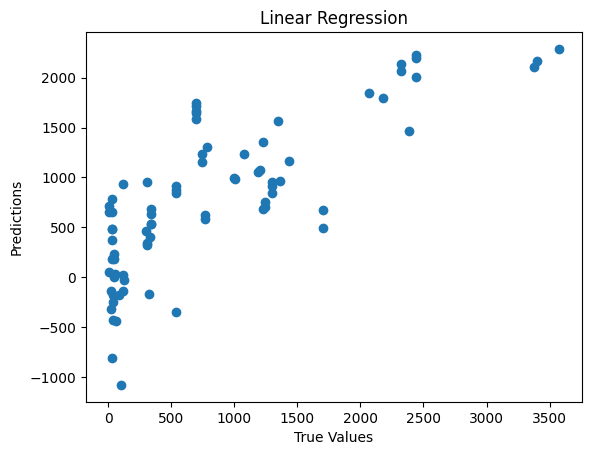

In [16]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression')

In [17]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,967.936082,396.563918,396.563918,1.572629e+05
371,1700.9900,495.992920,1204.997080,1204.997080,1.452018e+06
248,89.9900,-176.703391,266.693391,266.693391,7.112536e+04
55,337.2200,681.049488,-343.829488,343.829488,1.182187e+05
390,101.2400,-1076.582302,1177.822302,1177.822302,1.387265e+06
...,...,...,...,...,...
364,2384.0700,1460.300843,923.769157,923.769157,8.533495e+05
82,1240.4545,707.305713,533.148787,533.148787,2.842476e+05
114,699.0982,1745.982257,-1046.884057,1046.884057,1.095966e+06
3,33.6442,479.414965,-445.770765,445.770765,1.987116e+05


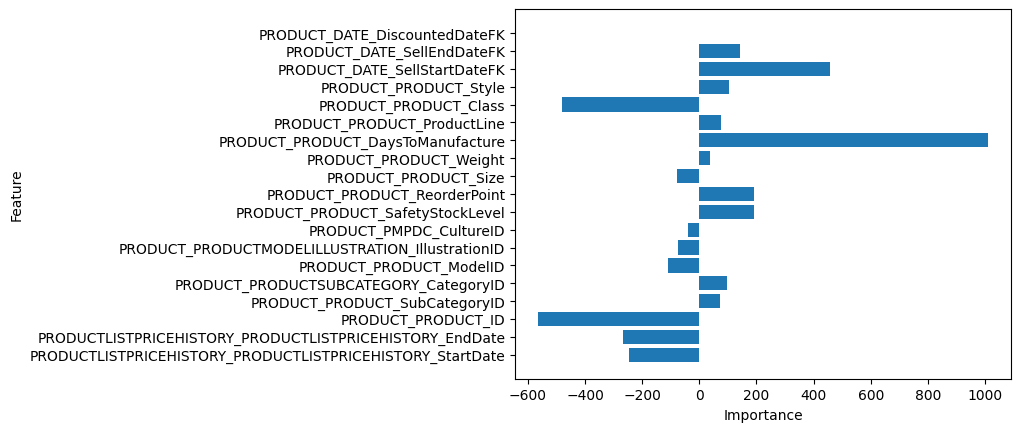

In [18]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_)

### Decision Tree

In [19]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [20]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [21]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 16892.400888988745
R2 Score: 0.9785465194341063


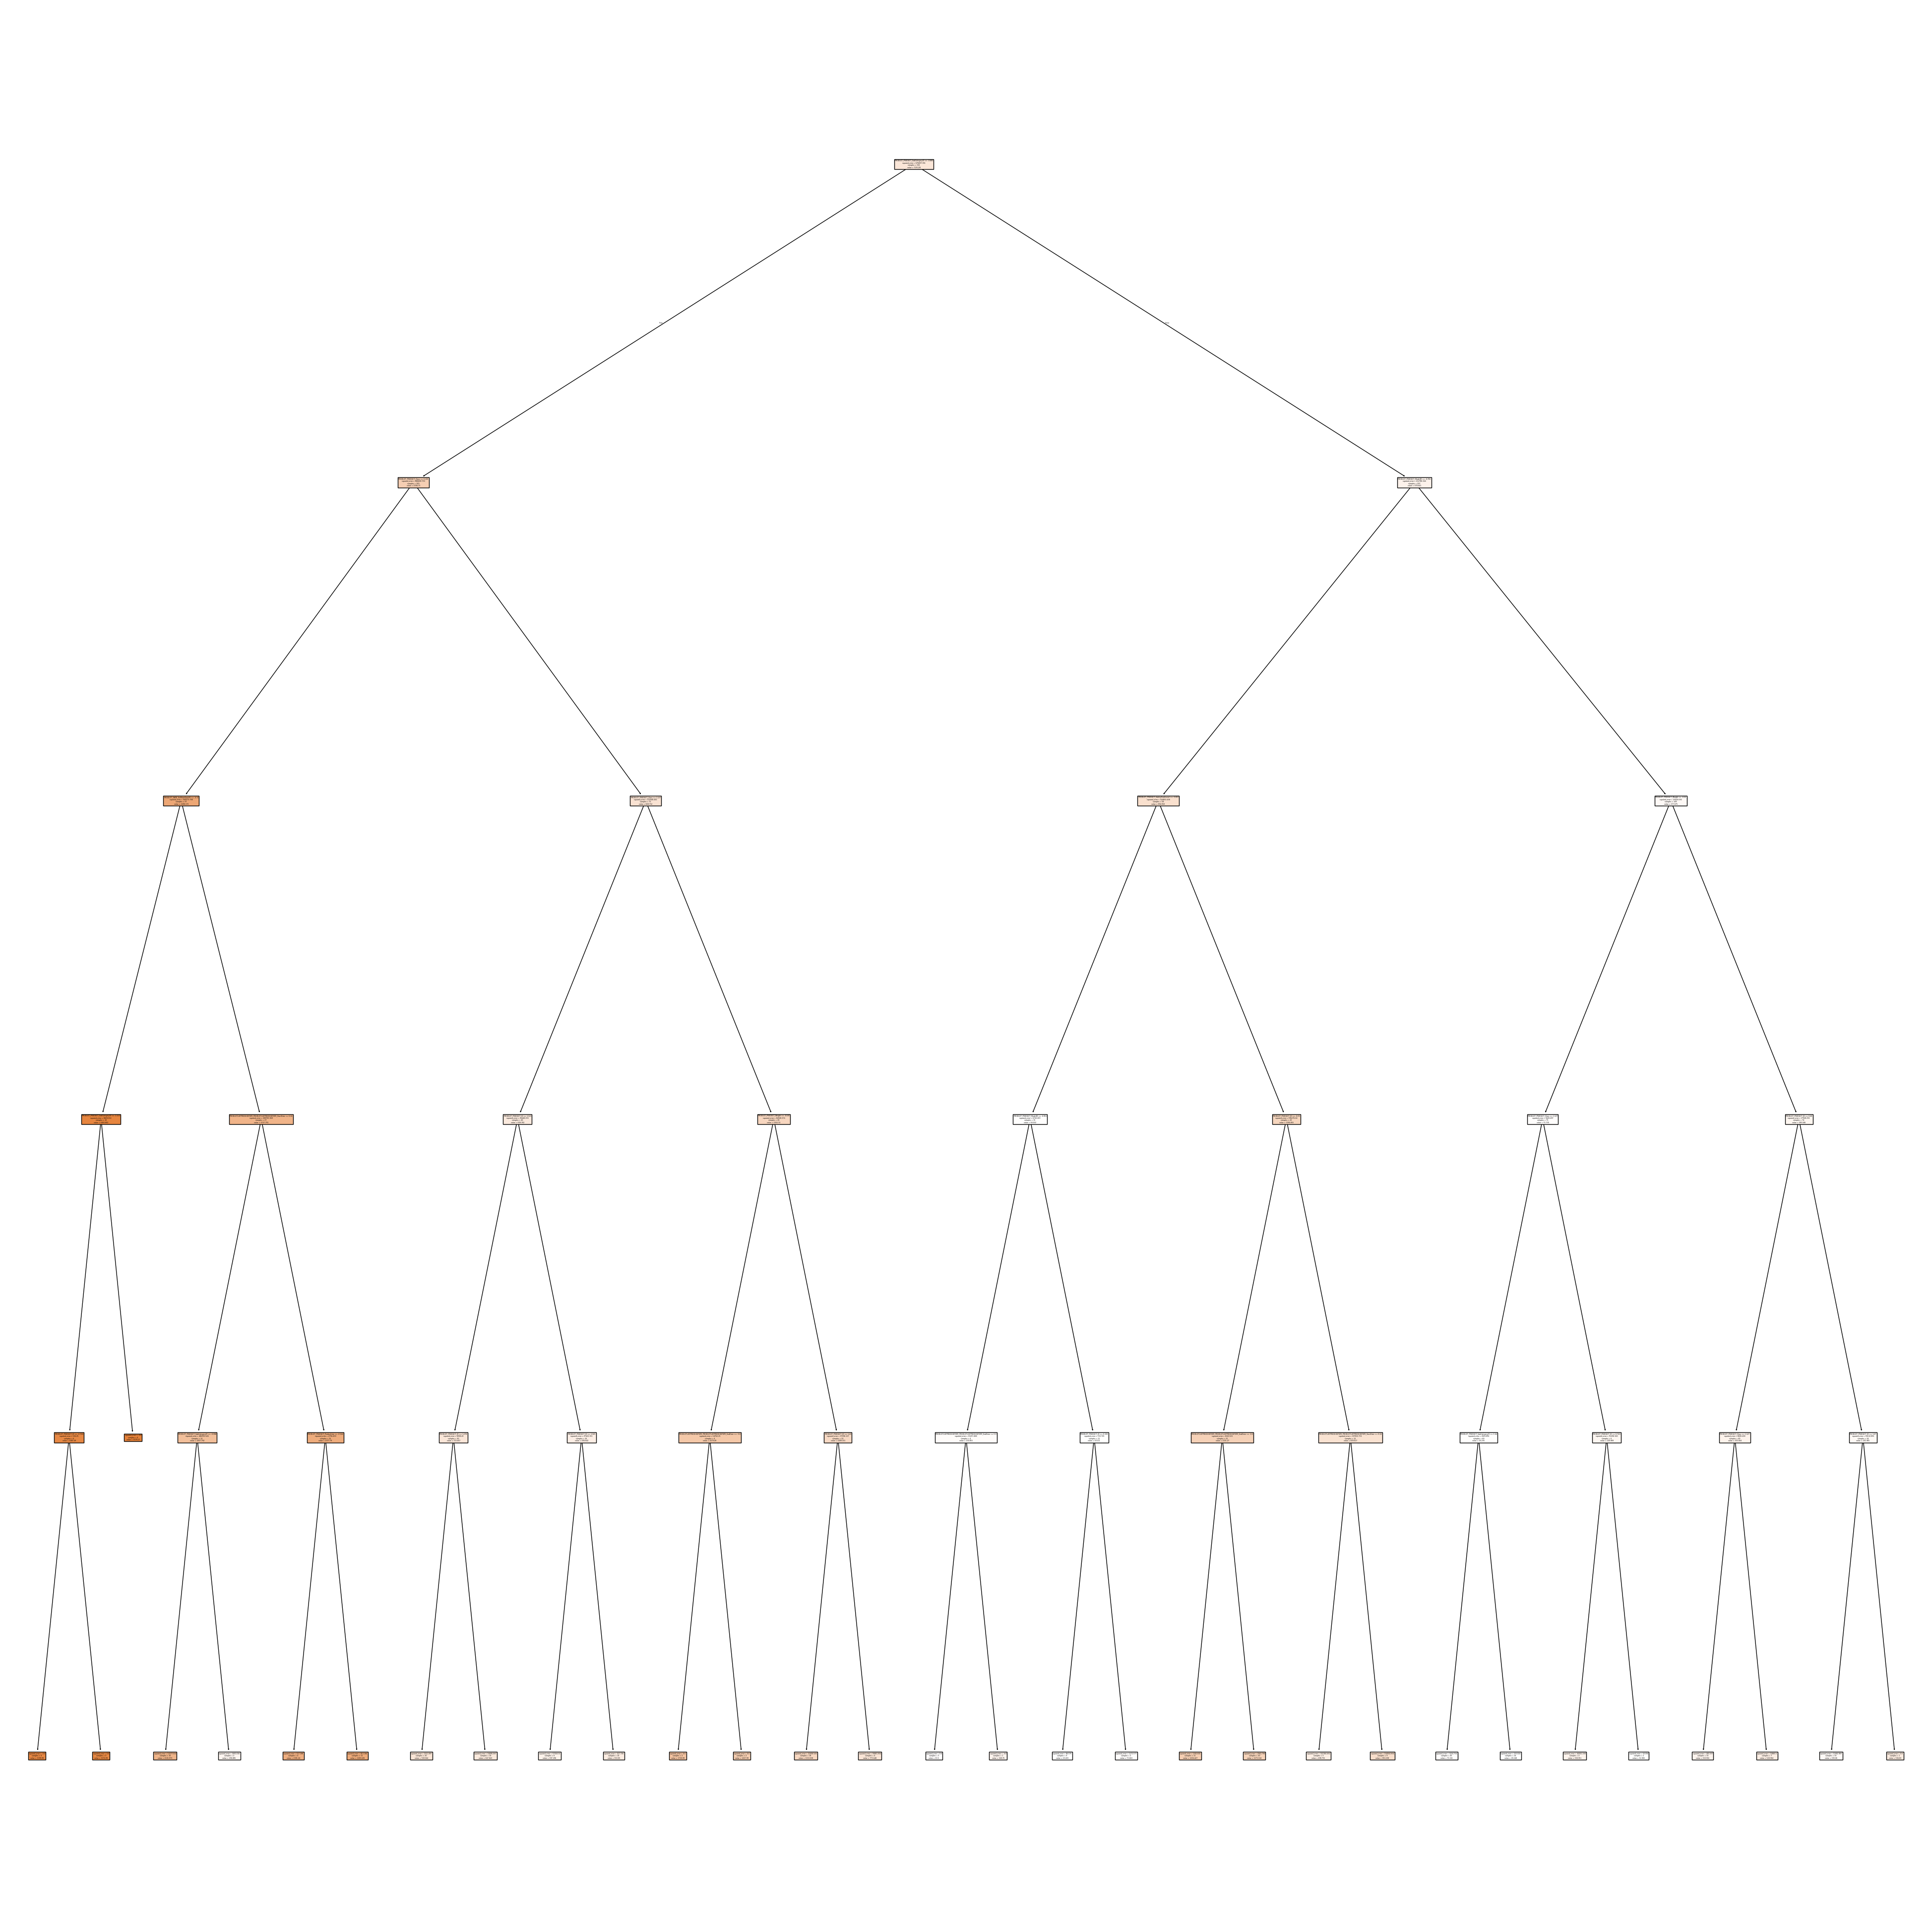

In [22]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [23]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1404.427273,-39.927273,39.927273,1594.187107
371,1700.9900,1700.990000,0.000000,0.000000,0.000000
248,89.9900,71.160973,18.829027,18.829027,354.532245
55,337.2200,318.916073,18.303927,18.303927,335.033754
390,101.2400,594.830000,-493.590000,493.590000,243631.088100
...,...,...,...,...,...
364,2384.0700,2405.626364,-21.556364,21.556364,464.676813
82,1240.4545,1275.533900,-35.079400,35.079400,1230.564304
114,699.0982,749.563870,-50.465670,50.465670,2546.783849
3,33.6442,28.247854,5.396346,5.396346,29.120548


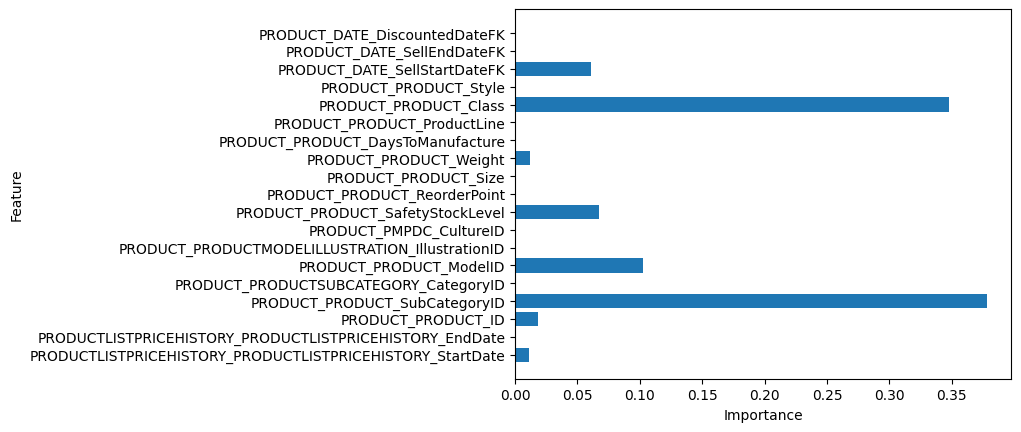

In [24]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_)

### Random Forest

In [25]:
# fitting the model
rfr_model = RandomForestRegressor(n_estimators=100)

rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [26]:
# predicting the values
rfr_y_pred = rfr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [27]:
# calculating the metrics
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
rfr_r2 = r2_score(y_test, rfr_y_pred)
print(f'Mean Squared Error: {rfr_mse}')
print(f'R2 Score: {rfr_r2}')

Mean Squared Error: 15589.874160997053
R2 Score: 0.9802007385133932


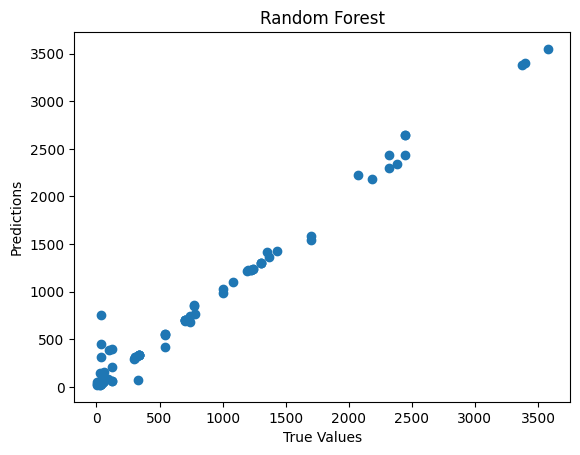

In [28]:
# plotting the results
plot_predictions(y_test, rfr_y_pred, 'Random Forest')

In [29]:
# dataframe with the predictions and the actual values, plus other metrics
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_y_pred})
rfr_results['Difference'] = rfr_results['Actual'] - rfr_results['Predicted']
rfr_results['Absolute Difference'] = np.abs(rfr_results['Difference'])
rfr_results['Squared Difference'] = rfr_results['Difference'] ** 2

rfr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1359.731000,4.769000e+00,4.769000e+00,2.274336e+01
371,1700.9900,1545.443000,1.555470e+02,1.555470e+02,2.419487e+04
248,89.9900,84.900913,5.089087e+00,5.089087e+00,2.589880e+01
55,337.2200,335.687180,1.532820e+00,1.532820e+00,2.349537e+00
390,101.2400,383.880900,-2.826409e+02,2.826409e+02,7.988588e+04
...,...,...,...,...,...
364,2384.0700,2343.363800,4.070620e+01,4.070620e+01,1.656995e+03
82,1240.4545,1234.562712,5.891788e+00,5.891788e+00,3.471317e+01
114,699.0982,699.098200,2.273737e-13,2.273737e-13,5.169879e-26
3,33.6442,32.783522,8.606780e-01,8.606780e-01,7.407666e-01


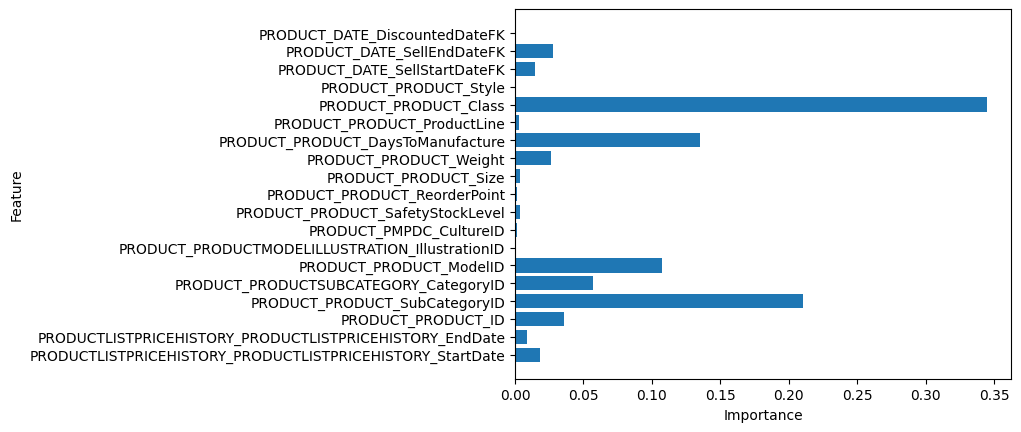

In [30]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, rfr_model.feature_importances_)

### Gradient Boosting

In [31]:
# fitting the model
gbr_model = GradientBoostingRegressor(n_estimators=100)

gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [32]:
# predicting the values
gbr_y_pred = gbr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [33]:
# calculating the metrics
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f'Mean Squared Error: {gbr_mse}')
print(f'R2 Score: {gbr_r2}')

Mean Squared Error: 22598.577156063136
R2 Score: 0.9712996311761417


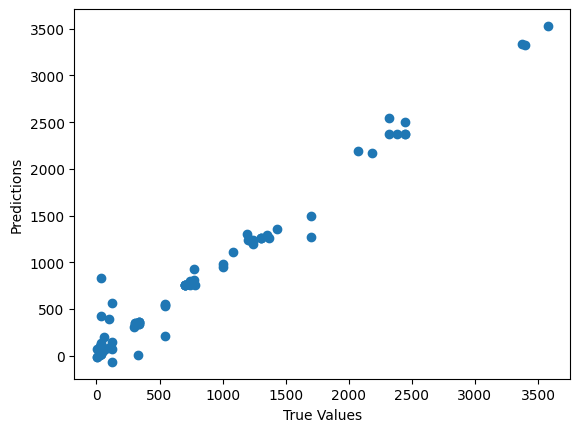

In [34]:
# plotting the results
plt.scatter(y_test, gbr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [35]:
# dataframe with the predictions and the actual values, plus other metrics
gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_y_pred})
gbr_results['Difference'] = gbr_results['Actual'] - gbr_results['Predicted']
gbr_results['Absolute Difference'] = np.abs(gbr_results['Difference'])
gbr_results['Squared Difference'] = gbr_results['Difference'] ** 2

gbr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1254.646613,109.853387,109.853387,12067.766531
371,1700.9900,1269.104402,431.885598,431.885598,186525.169685
248,89.9900,81.098740,8.891260,8.891260,79.054496
55,337.2200,356.160820,-18.940820,18.940820,358.754669
390,101.2400,390.428290,-289.188290,289.188290,83629.867160
...,...,...,...,...,...
364,2384.0700,2368.616818,15.453182,15.453182,238.800834
82,1240.4545,1238.375633,2.078867,2.078867,4.321689
114,699.0982,754.694341,-55.596141,55.596141,3090.930883
3,33.6442,18.971437,14.672763,14.672763,215.289965


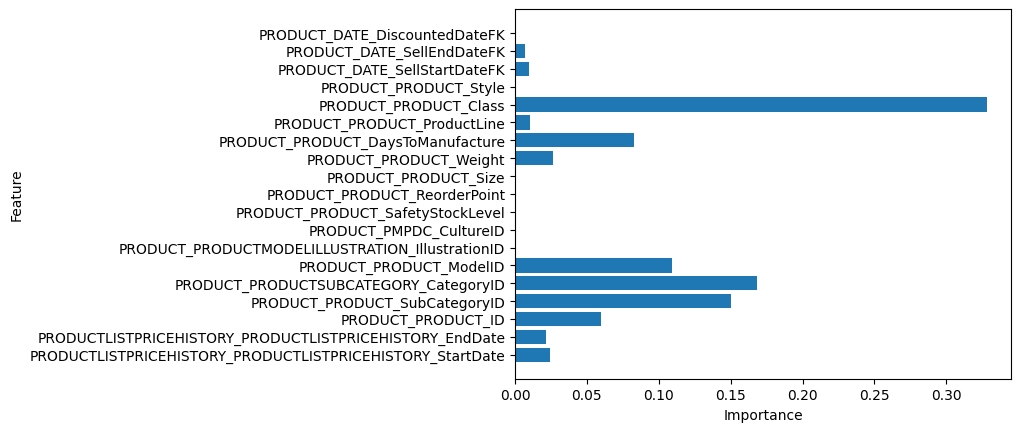

In [36]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, gbr_model.feature_importances_)

### Pytorch Network

In [37]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [38]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 34751709184.0
Epoch 100, Loss: 506930.65625
Epoch 200, Loss: 950556.875
Epoch 300, Loss: 500026.15625
Epoch 400, Loss: 1780807.25
Epoch 500, Loss: 1382720.375
Epoch 600, Loss: 764957.0625
Epoch 700, Loss: 2091790.125
Epoch 800, Loss: 3422685.25
Epoch 900, Loss: 1164774.0


#### Calculating the metrics and visualizing the results

In [39]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 762371.5
Average R2 Score: -0.12405810753504436


In [40]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,1364.500000,810.713501,553.786499,553.786499,3.066795e+05
1,1700.989990,811.465454,889.524536,889.524536,7.912539e+05
2,89.989998,1074.304321,-984.314331,984.314331,9.688747e+05
3,337.220001,1073.919556,-736.699585,736.699585,5.427262e+05
4,101.239998,811.445923,-710.205933,710.205933,5.043925e+05
...,...,...,...,...,...
74,2384.070068,811.466431,1572.603638,1572.603638,2.473082e+06
75,1240.454468,1091.442993,149.011475,149.011475,2.220442e+04
76,699.098206,1073.657837,-374.559631,374.559631,1.402949e+05
77,33.644199,1091.196899,-1057.552734,1057.552734,1.118418e+06


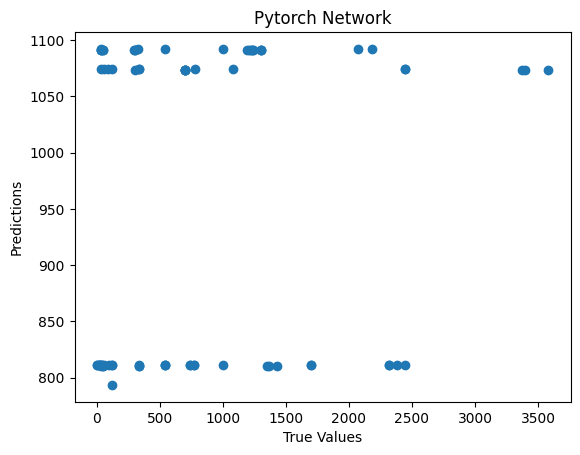

In [41]:
# plotting the results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network')